<a href="https://colab.research.google.com/github/finfrierson/data-science-fundamentals/blob/main/Unit8ExercisesSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unit 8 Exercises: The Art of BART

These exercises are grouped into two parts:

- Questions on the nature of decision trees, random forests, and BART models
- An oppurtunity to practice implementing and analyzing a BART model.

Enjoy!

## Bartian Theory

**Task1**:

Draw a decision tree--on a physical piece of paper--that predicts how much time you'll spend studying on a given day, using the amount of sleep you got the night before as a predictor.

If this seems to easy, then add another variable or two (test tomorrow? activity after school?), and/or increase the depth of your tree.

You do not have to show me or turn in your tree to earn credit for this question, although I would like to see your drawing.

**Task2**:

What is a decision tree? How do they work?

A decision tree is a type of model that has different outcomes based on the values of other factors. It works by determining these values then going down the tree in accordance to those factors, ex. having 9 hrs of sleep choosing a >8 hour path not the <8 path.

**Task3**:

What does the "depth" of a decision tree mean?

How do I know if a tree is too deep, or not deep enough?

The depth of a decision tree is the number of decisions to make before reaaching the leafs. To be the proper depth it should account for most or all important factors. It will be too deep if factors are used that do not change the result, and not deep enough if there are very obvious predictors that go unnaccouunted for, harming your tree

**Task4:**

How are BART models similar and different from a decision tree?

While a decision tree models very specific choices individually, BART models combine a variety of randomized trees with differences, thus creating a model which knows all the patterns rather than sepcific ones.

**Task5**:

Why would we use a BART model instead of a decision tree?

Because knowing all the trends rather than just a few allows your model to encapsulate all trends, and thus not let you miss any important details. Interractions between variables are also modeled best with a random forest like bart.

## Bartian Penguins

**Task6**:

Create a BART model that uses flipper length, bill depth, and bill length to predict body mass in penguins, and make a ppc to check its fit

Code for loading the data is below. You'll need to do everything else yourself.

Remember to use my notes as a reference, and to copy and paste from them when it makes sense to.

Oh, and try a normal likelihood.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import seaborn as sns
!pip install pymc-bart
import pymc_bart as pmb

In [2]:
#drop the incomplete rows from the data
url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/main/Data/penguins.csv"
penguins = pd.read_csv(url).dropna()


In [3]:
penguins

,species,island,bill_length,bill_depth,flipper_length,body_mass,sex,year
0,Adelie,Torgersen,3.91,1.87,18.1,3.750,male,2007
1,Adelie,Torgersen,3.95,1.74,18.6,3.800,female,2007
2,Adelie,Torgersen,4.03,1.80,19.5,3.250,female,2007
4,Adelie,Torgersen,3.67,1.93,19.3,3.450,female,2007
5,Adelie,Torgersen,3.93,2.06,19.0,3.650,male,2007
...,...,...,...,...,...,...,...,...
339,Chinstrap,Dream,5.58,1.98,20.7,4.000,male,2009
340,Chinstrap,Dream,4.35,1.81,20.2,3.400,female,2009
341,Chinstrap,Dream,4.96,1.82,19.3,3.775,male,2009
342,Chinstrap,Dream,5.08,1.90,21.0,4.100,male,2009


In [16]:
X = penguins[[
             'flipper_length',
             'bill_depth',
             'bill_length']]
Y = penguins["body_mass"].to_numpy()

In [17]:
with pm.Model() as model_octps:
    s = pm.HalfNormal('s',15)
    μ_ = pmb.BART("μ_", X, np.log(Y), m=50)
    μ = pm.Deterministic("μ",pm.math.exp(μ_))
    y = pm.Normal("y", mu=μ, sigma=s,  observed=Y)
    idata_peng = pm.sample(compute_convergence_checks=False)

Output()

In [18]:
pm.sample_posterior_predictive(idata_peng,model_octps, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

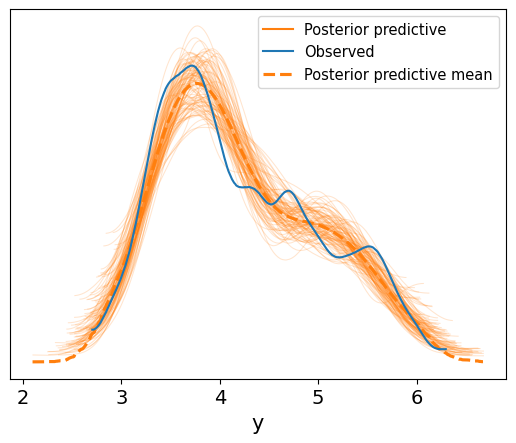

In [19]:
ax = az.plot_ppc(idata_peng, num_pp_samples=100, colors=["C1", "C0", "C1"])

**Task7**:

Plot flipper length versus body mass,

and then plot the posterior predictve from the model over the data.
You're going to copy paste the plotting code from the notes, fyi.

In [20]:
posterior_mean = idata_peng.posterior["μ"]

μ_hdi = az.hdi(ary=idata_peng, group="posterior", var_names=["μ"], hdi_prob=0.74)

pps = az.extract(
    idata_peng, group="posterior_predictive", var_names=["y"]
).T

/usr/local/lib/python3.11/dist-packages/arviz/plots/hdiplot.py:166: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


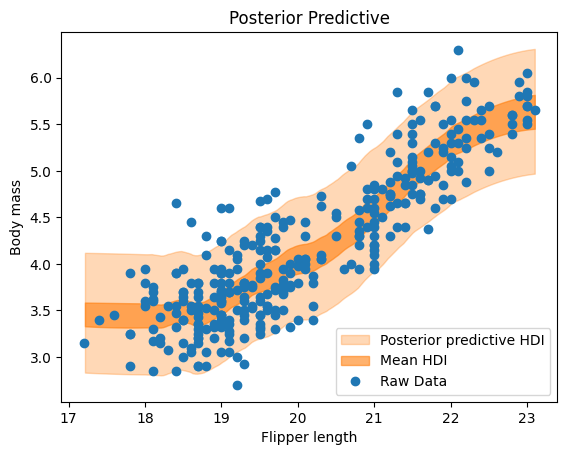

In [9]:
idx = np.argsort(X.to_numpy()[:, 2]) #grab fifth row
fig, ax = plt.subplots()

az.plot_hdi(
    x=X.to_numpy()[:, 2],#grab fifth row
    y=pps,
    ax=ax,
    hdi_prob=0.93,
    fill_kwargs={"alpha": 0.3, "label": r"Posterior predictive HDI"},
)

az.plot_hdi(
    x=X.to_numpy()[:, 2],#grab fifth row
    y=posterior_mean,
    ax=ax,
    hdi_prob=0.74,
    fill_kwargs={"alpha": 0.6, "label": r"Mean HDI"},
)
ax.plot(penguins['flipper_length'], penguins["body_mass"], "o", c="C0", label="Raw Data")
ax.legend(loc="lower right")
ax.set(
    title="Posterior Predictive",
    xlabel="Flipper length",
    ylabel="Body mass",
);

**Task8**:

Interpret the plot above in context. Do you think it captures the true association between flipper length and body mass in penguins? Why or why not? Make sure to reference specific things you see in the plot.

I think that it captures the true association relativeky well. The posterior predictive encompases the vast majority of the points with the mean HDI running straight through the center of the points.

**Task9**:

Create partial depnedence plots (pdps), individual conditional expectation (ice) plots, and a variable importance plot for the BARTpenguin model.

array([<Axes: xlabel='bill_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='flipper_length'>], dtype=object)

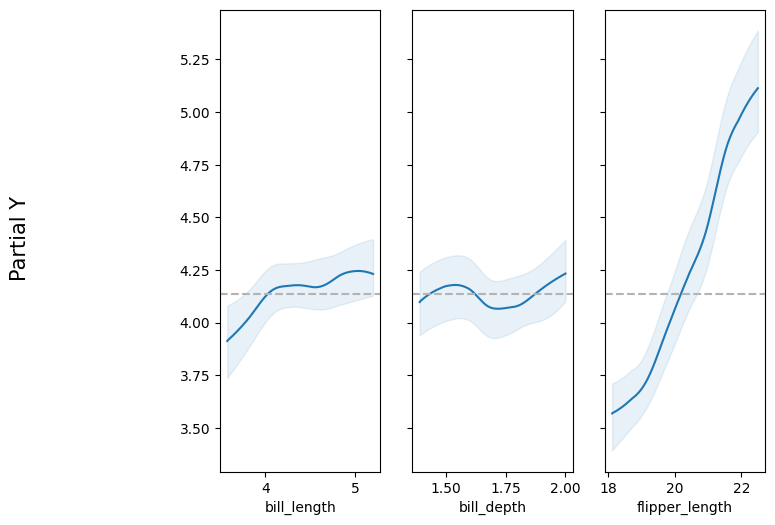

In [10]:
pmb.plot_pdp(μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

array([<Axes: xlabel='bill_length'>, <Axes: xlabel='bill_depth'>,
       <Axes: xlabel='flipper_length'>], dtype=object)

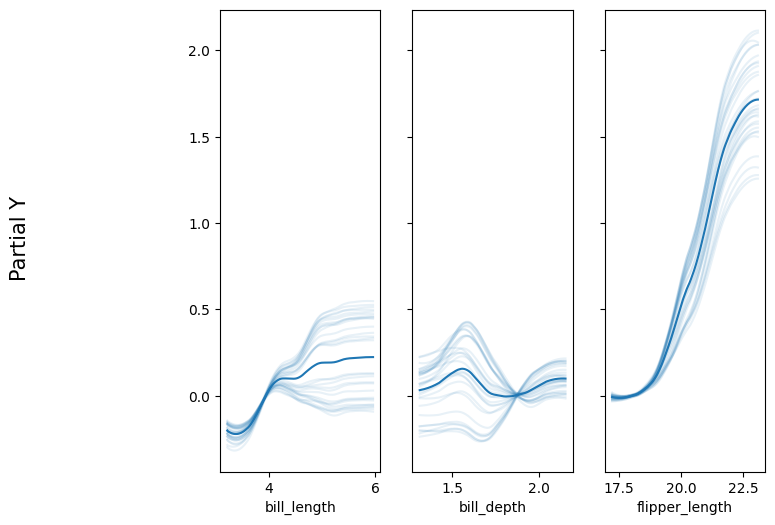

In [11]:
pmb.plot_ice( μ_, X, Y, grid=(1, 5), func=np.exp, figsize = (12,6))

In [14]:
vi_peng = pmb.compute_variable_importance(idata_peng, μ_, X)

<Axes: ylabel='R²'>

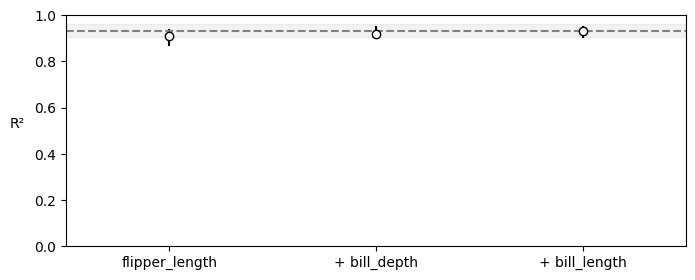

In [15]:
pmb.plot_variable_importance(vi_peng)

**Task10**:

Using the above plots, make an argument about which variable(s) is/are most important in predicting body mass in penguins.

What is the relationship for each variable to body mass, when you take the other variables into account?

Is that relationship complicated by interactions between variables? How do you know?

Make sure to reference specific things you see in each plot, to justify your decisions and comments.

While all of the variables appear to have impact, flipper length appears to be the most important by far. From the pdpfs, we can see a very small increasing trend for both of the bill statistics, whereass with flipper length you can see the body mass shoot up rapidly. A similar trend is seen in the ICE plot, also showing the model to be very confident in this extreme shot up at the start. Lastly, from the VI plot, we can see that a model with only flipper length as a factor is already so close to as good as a model with all three variable, meaning it is likely the most important preditctor. Overalll between all of this I can tell that flipper lenth is most important in predicting body mass in penguins